In [10]:
import tensorflow as tf

PARAMS = {
    'data_dir':'/home/ubuntu/intelliscope/for_dataloaders/waveletcomb1/dataNotA/pcg/balanced',
    'modelsave_dir':'/home/ubuntu/intelliscope/models',
    'modelload_dir':'', 
    'num_epochs': 10,
    'validation_split':0.1,
    'test_split': 0.2,
    'batch_size':32,
    'data_balanced':True,
    'wavelet':'comb1',
    'dataset':'physionet2016bcdef',
    'pcg/ecg': 'pcg',
    'augmentation':0,
    'model':'base',
    'opt':tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    'tags':['CASS'],
    'pretrained': False,
    'notebook_name':'pcg01_balanced.ipynb',
    'description':'initial model architecture from CASS paper (base model)',
    'name':'data_bcdef + balanced'
}


data_dir=PARAMS['data_dir']
modelsave_dir=PARAMS['modelsave_dir']
modelload_dir=PARAMS['modelload_dir']

In [2]:
import os
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda,BatchNormalization
from tensorflow.keras import backend as K
from tensorflow_addons.layers import InstanceNormalization

from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
if PARAMS['pretrained']==True:
    model=load_model(modelload_dir)
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(4, kernel_size=(7,7), padding='same', activation='relu', input_shape=(272,462, 3)),
        tf.keras.layers.MaxPool2D(pool_size=(3,3)),
        tf.keras.layers.Conv2D(16, kernel_size=(7,7), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(3,3)),
        tf.keras.layers.Conv2D(32, kernel_size=(7,7), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(3,3)),
        tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(84, activation='relu'),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])



model.compile(optimizer=PARAMS['opt'], 
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()])


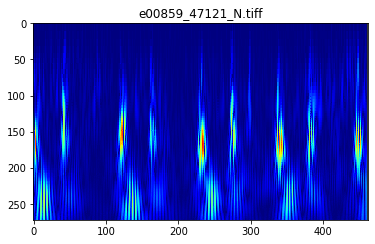

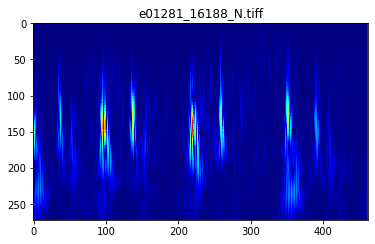

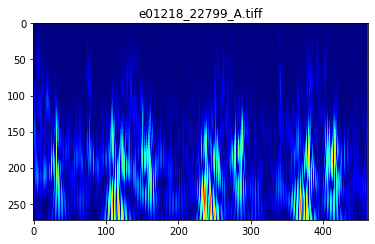

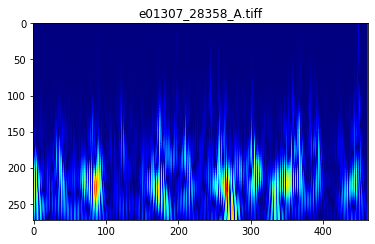

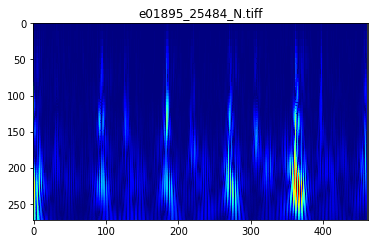

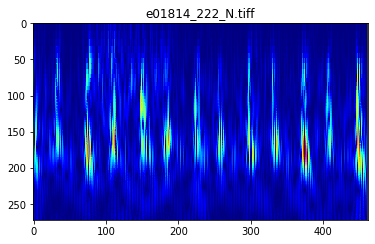

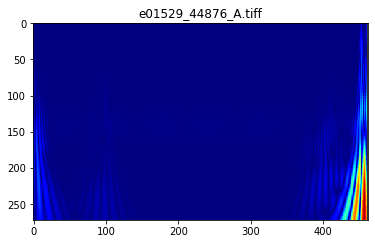

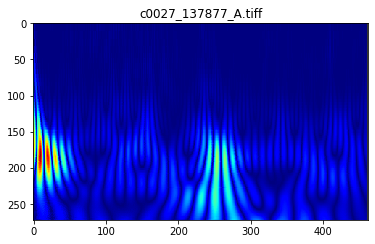

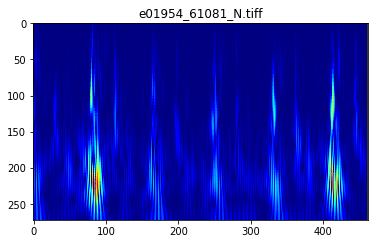

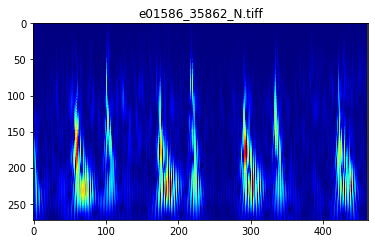

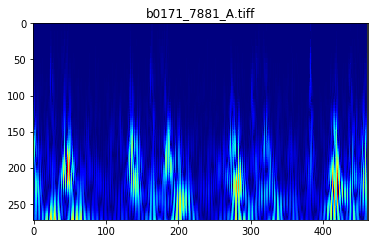

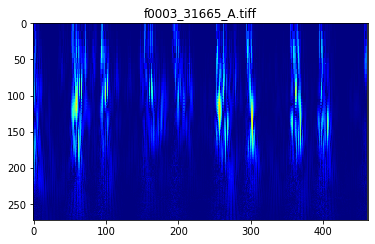

In [4]:
from intelliscope import rescale, check_rescale

'''
rescale(data_dir+'/train/0')
rescale(data_dir+'/train/1')
rescale(data_dir+'/val/0')
rescale(data_dir+'/val/1')
rescale(data_dir+'/test/0')
rescale(data_dir+'/test/1')
'''
check_rescale(data_dir+'/train/0')
check_rescale(data_dir+'/train/1')
check_rescale(data_dir+'/val/0')
check_rescale(data_dir+'/val/1')
check_rescale(data_dir+'/test/0')
check_rescale(data_dir+'/test/1')


In [ ]:
batch_size=PARAMS['batch_size']

import numpy as np
#train_datagen = ImageDataGenerator(
#        rescale=1./255,
#        shear_range=0.2,
#        zoom_range=0.2,
#        horizontal_flip=True)

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_dir+'/train',
    target_size=(272, 462),  
    batch_size=PARAMS['batch_size'],
    class_mode='categorical',
    shuffle=True,
    seed=10)

val_generator = val_datagen.flow_from_directory(
    data_dir+'/val',
    target_size=(272, 462),  
    batch_size=PARAMS['batch_size'],
    class_mode='categorical',
    shuffle=True,
    seed=10)


history=model.fit_generator(
        train_generator,
        epochs=PARAMS['num_epochs'],
        validation_data=val_generator)

Found 3005 images belonging to 2 classes.
Found 406 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.


/home/ubuntu/core-env/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 94 steps, validate for 13 steps
Epoch 1/10
94/94 [==============================] - 150s 2s/step - loss: 0.5012 - categorical_accuracy: 0.7651 - val_loss: 0.3812 - val_categorical_accuracy: 0.8202
Epoch 2/10
16/94 [====>.........................] - ETA: 2:17 - loss: 0.3240 - categorical_accuracy: 0.8477

In [ ]:
#!pip install neptune-client
import os
import neptune
NEPTUNE_API_TOKEN='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiMzc1YTM5OGMtYTY3Ny00ZmM4LTg5ZGQtOGI2YTQ1YmZiMDkzIn0='
os.environ['NEPTUNE_PROJECT']="intelliscope/PCG"

neptune.init('intelliscope/PCG',NEPTUNE_API_TOKEN)
exp = neptune.create_experiment(name=PARAMS['name'],description=PARAMS['description'],params=PARAMS,upload_source_files=PARAMS['notebook_name'],tags=PARAMS['tags'],upload_stdout=True)

model.summary(print_fn=lambda x: neptune.log_text('model_summary', x))
model.save(f'{modelsave_dir}/{str(exp)}.h5')
neptune.log_artifact(f'{modelsave_dir}/{str(exp)}.h5')

for i in range(len(history.history['loss'])):
    neptune.log_metric('loss',history.history['loss'][i])
    neptune.log_metric('val loss',history.history['val_loss'][i])
    neptune.log_metric('categorical_acc',history.history['categorical_accuracy'][i])
    neptune.log_metric('val_categorical_acc',history.history['val_categorical_accuracy'][i])

# Test and Log results on test data

In [ ]:
import numpy as np
from neptunecontrib.monitoring.metrics import *

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        data_dir+'/test',  # this is the target directory
        target_size=(272, 462),  # all images will be resized to 150x150
        batch_size=len(os.listdir(data_dir+'/test/1'))+len(os.listdir(data_dir+'/test/0')),
        class_mode='categorical', seed=7)

X,y = test_generator.next()
prediction = model.predict(X)


y_test=np.argmax(y,axis=1)
y_pred=prediction

threshold = 0.5

log_confusion_matrix(y_test, y_pred[:, 1] > threshold)
log_classification_report(y_test, y_pred[:, 1] > threshold)
log_class_metrics(y_test, y_pred[:, 1] > threshold)
log_class_metrics_by_threshold(y_test, y_pred[:, 1])
log_brier_loss(y_test, y_pred[:, 1])
log_prediction_distribution(y_test, y_pred[:, 1])

log_log_loss(y_test, y_pred)
log_roc_auc(y_test, y_pred)
log_precision_recall_auc(y_test, y_pred)
log_ks_statistic(y_test, y_pred)
log_cumulative_gain(y_test, y_pred)
log_lift_curve(y_test, y_pred)

In [ ]:
neptune.stop()